In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [24]:
# Load data
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [25]:
# view basic data set stats
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [26]:
# Check for missing values
missing_cols = df.columns[df.isnull().any()]

# Display columns with missing values and the count of missing values in each
missing_info = df[missing_cols].isnull().sum()
print(missing_info)

Age         177
Cabin       687
Embarked      2
dtype: int64


In [27]:
# Calculate mean and standard deviation from train_df
age_mean = df['Age'].mean()
age_std = df['Age'].std()

# Apply changes to both train and test sets
for dataset in [df, df_test]:
    # Count the number of missing values in 'Age'
    is_null = dataset['Age'].isnull().sum()
    
    # Generate random ages within the range [mean - std, mean + std] for each missing value
    rand_age = np.random.randint(age_mean - age_std, age_mean + age_std, size=is_null)
    
    # Fill in missing values in 'Age' with generated random values
    age_slice = dataset['Age'].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset['Age'] = age_slice.astype(int)  # Convert to integer if desired

In [28]:
# df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# df_test['Age'].fillna(df_test['Age'].median(), inplace=True)
df_test['Embarked'].fillna(df_test['Embarked'].mode()[0], inplace=True)

C:\Users\mattias.hoehnen\AppData\Local\Temp\ipykernel_23432\3475263538.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
C:\Users\mattias.hoehnen\AppData\Local\Temp\ipykernel_23432\3475263538.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [29]:
# create fam size feature
df['Fam Size'] = df['Parch'] + df['SibSp'] + 1
df['Is Alone'] = df['Fam Size'] < 2

df_test['Fam Size'] = df_test['Parch'] + df_test['SibSp'] + 1
df_test['Is Alone'] = df_test['Fam Size'] < 2

In [30]:
# Avg Fare
df['Avg Fare'] = df['Fare'] / df['Fam Size']
df_test['Avg Fare'] = df_test['Fare'] / df_test['Fam Size']


# Age Class
df['Age Class'] = df['Age'] * df['Pclass']
df_test['Age Class'] = df_test['Age'] * df_test['Pclass']

# Age Fare
df['Age Fare'] = df['Age'] * df['Fare']
df_test['Age Fare'] = df_test['Age'] * df_test['Fare']

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fam Size,Is Alone,Avg Fare,Age Class,Age Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,2,False,3.62500,66,159.5000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,2,False,35.64165,38,2708.7654
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1,True,7.92500,78,206.0500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,2,False,26.55000,35,1858.5000
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,True,8.05000,105,281.7500


In [31]:
# create a new feature to extract title names from the Name column
df['Title'] = df.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
df_test['Title'] = df_test.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
# normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}
# map the normalized titles to the current titles 
df.Title = df.Title.map(normalized_titles)
df_test.Title = df_test.Title.map(normalized_titles)

# view value counts for the normalized titles
print(df.Title.value_counts())

df.head()

Title
Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: count, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fam Size,Is Alone,Avg Fare,Age Class,Age Fare,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,2,False,3.62500,66,159.5000,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,2,False,35.64165,38,2708.7654,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1,True,7.92500,78,206.0500,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,2,False,26.55000,35,1858.5000,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,True,8.05000,105,281.7500,Mr


In [32]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Fam Size,Avg Fare,Age Class,Age Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.479237,0.523008,0.381594,32.204208,1.904602,19.916375,64.471380,1009.115737
std,257.353842,0.486592,0.836071,13.502408,1.102743,0.806057,49.693429,1.613459,35.841257,34.162632,1800.377647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400,1.000000,7.250000,40.000000,202.254400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,8.300000,60.000000,354.737500
75%,668.500000,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000,2.000000,23.666667,84.000000,1079.300700
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,512.329200,222.000000,18443.851200


In [33]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Fam Size,Avg Fare,Age Class,Age Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,417.000000,418.000000,417.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.188995,0.447368,0.392344,35.627188,1.839713,21.804161,63.624402,1305.951809
std,120.810458,0.841838,13.224502,0.896760,0.981429,55.907576,1.519072,35.639766,30.572947,2714.798309
min,892.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,22.000000,0.000000,0.000000,7.895800,1.000000,7.629200,43.000000,205.290800
50%,1100.500000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,8.662500,60.000000,365.899200
75%,1204.750000,3.000000,38.750000,1.000000,0.000000,31.500000,2.000000,26.000000,81.750000,1115.100000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,11.000000,262.375000,180.000000,29715.093600


In [34]:
# Normalize fare and other numerical features

# Initialize the MinMaxScaler to scale features to the [0, 1] range
scaler = MinMaxScaler()

# Normalize selected numerical features in the training set
df[['Age', 'SibSp', 'Parch', 'Fare', 'Fam Size', 'Avg Fare', 'Age Class', 'Age Fare']] = scaler.fit_transform(
    df[['Age', 'SibSp', 'Parch', 'Fare', 'Fam Size', 'Avg Fare', 'Age Class', 'Age Fare']]
)
df.head()  # Display the first few rows to inspect the normalized values

# Normalize the same features in the test set using the scaler fitted on the training set
df_test[['Age', 'SibSp', 'Parch', 'Fare', 'Fam Size', 'Avg Fare', 'Age Class', 'Age Fare']] = scaler.transform(
    df_test[['Age', 'SibSp', 'Parch', 'Fare', 'Fam Size', 'Avg Fare', 'Age Class', 'Age Fare']]
)

In [35]:
# Handle Categorical data

# Convert the 'Sex' column to numerical values: 0 for male, 1 for female in the training set
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Convert categorical variables 'Pclass', 'Embarked', and 'Title' into one-hot encoded (dummy) variables in the training set
df = pd.get_dummies(df, columns=['Pclass', 'Embarked', 'Title'])

# Display the first few rows to inspect the changes
df.head()

# Repeat the same encoding for the test set
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})
df_test = pd.get_dummies(df_test, columns=['Pclass', 'Embarked', 'Title'])

In [37]:
# (Optional) Save the PassengerId column from the training set if needed for later use (currently commented out)
# passenger_id = df['PassengerId']

# Drop columns that are not useful for prediction from the training set
# 'PassengerId', 'Name', 'Ticket', and 'Cabin' are removed as they are either identifiers or contain too many missing values
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
df.head()  # Display the first few rows to inspect the changes

# Save the PassengerId column from the test set for use in the submission file
passenger_id_test = df_test['PassengerId']

# Drop the same unnecessary columns from the test set
df_test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

In [39]:
# Separate the features (X) and the target variable (y) from the training set
X = df.drop(columns='Survived')  # Features: all columns except 'Survived'
y = df['Survived']               # Target: the 'Survived' column

# Split the data into training and validation sets
# 90% for training, 10% for validation, using a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [40]:
# Initialize the Adam optimizer with a specified learning rate for use in training a neural network
optimizer = Adam(learning_rate=0.0005)

In [41]:
# Build a deep neural network model using Keras Sequential API

model = Sequential()

# Input and first hidden layer with 512 neurons, ReLU activation, and L2 regularization
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))  # Dropout layer to reduce overfitting

# Second hidden layer with 256 neurons, ReLU activation, and L2 regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

# Third hidden layer with 128 neurons, ReLU activation, and L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

# Fourth hidden layer with 64 neurons, ReLU activation, and L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

# Fifth hidden layer with 32 neurons, ReLU activation, and L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

# Output layer with 1 neuron and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

# Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\mattias.hoehnen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# Train the neural network model on the training data
history = model.fit(
    X_train,           # Training features
    y_train,           # Training labels
    validation_split=0.2,  # Use 20% of the training data for validation during training
    epochs=60,             # Number of epochs to train the model
    batch_size=32,         # Number of samples per gradient update
    verbose=True           # Print progress during training
)

Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6083 - loss: 1.3209 - val_accuracy: 0.7640 - val_loss: 1.1584
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7112 - loss: 1.1931 - val_accuracy: 0.8199 - val_loss: 1.0301
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7617 - loss: 1.1000 - val_accuracy: 0.8261 - val_loss: 0.9516
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7983 - loss: 0.9952 - val_accuracy: 0.8199 - val_loss: 0.9018
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7999 - loss: 0.9883 - val_accuracy: 0.8385 - val_loss: 0.8715
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8418 - loss: 0.8925 - val_accuracy: 0.8634 - val_loss: 0.8416
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8360 - loss: 0.8594 - val_accuracy: 0.8137 - val_loss: 0.8222
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8162 - loss: 0.8506 - val_accuracy: 0.8385 - val_loss

In [45]:
# Evaluate the trained neural network model on the validation (test) set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print(f"Test accuracy: {test_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8174 - loss: 0.5432 
Test accuracy: 0.8222


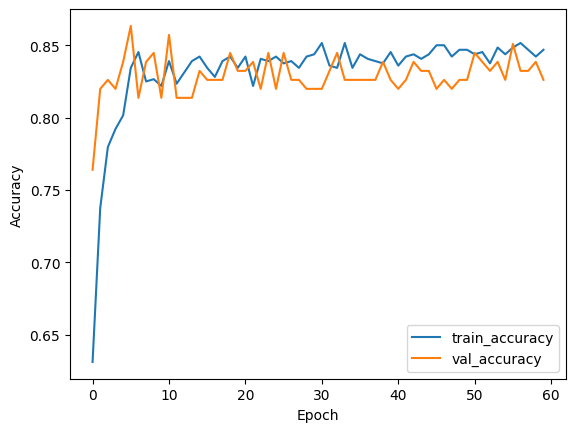

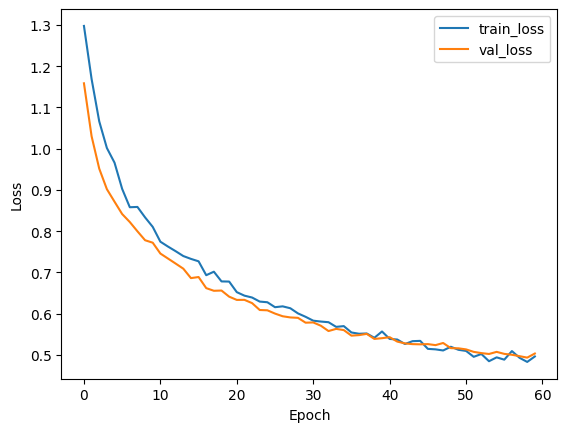

In [46]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Evaluate on test set
predictions = model.predict(df_test)

#Since Kaggle expects binary predictions, round them to 0 or 1
predictions = (predictions > 0.5).astype(int).flatten()  # Rounding sigmoid output to 0 or 1

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [51]:
# Assuming test_df has 'PassengerId' column
submission = pd.DataFrame({
    'PassengerId': passenger_id_test,
    'Survived': predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)